### Validating a pipeline with test data
---
* if you don't have it, get it with `pip install opencv-python`
* i added training photos to the training_images folder

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import pandas as pd
import time
#from skimage.draw import disk

### open and display an image with matplotlib

In [3]:
pwd

'C:\\Cory\\CJH Shared\\Python\\FRC\\FRC_training\\notebooks\\vision\\optimization'

In [4]:
cd "training_images/workshop_2023"

C:\Cory\CJH Shared\Python\FRC\FRC_training\notebooks\vision\optimization\training_images\workshop_2023


In [5]:
files = glob.glob('*.jpg', recursive=True)
len(files)

3

### start a pipeline

In [10]:
import spartan_overlay_2023 as spo
from importlib import reload
reload(spo)

<module 'spartan_overlay_2023' from 'C:\\Cory\\CJH Shared\\Python\\FRC\\FRC_training\\notebooks\\vision\\optimization\\spartan_overlay_2023.py'>

In [11]:
colors = ['yellow', 'purple', 'green']
camera='lifecam'
pipeline_all = spo.SpartanOverlay(colors=colors, camera=camera)
pipelines = [spo.SpartanOverlay(colors=[c], camera=camera) for c in colors]
#pipelines[1]._hsv_threshold_value = [60, 255]

In [12]:
# set a wide range and derive best values
test_hues = {'yellow': [14, 22], 
             'green': [78, 90], 
             'purple': [116, 130], 
             'blue': [], 
             'red': []}
test_sats = {'all': [100, 255]}
test_vals = {'all': [60, 255]}

#### test all at once
#### todo: take out the pixels that are in the contour but not the object

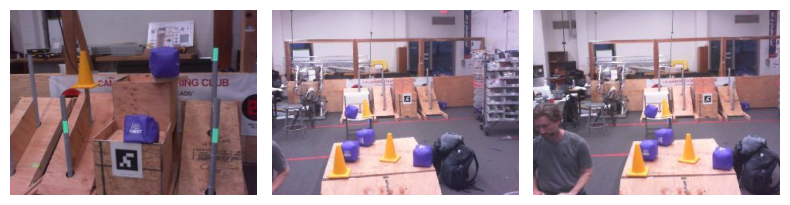

In [54]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,6))
for ix, (file, ax) in enumerate(zip(files,axs)):
    img_rgb = cv2.imread(file)  # pipeline expects BGR
    ax.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
    ax.axis('off')
fig.tight_layout()

In [58]:
stats = {}
pimages = []
[stats.update({c:{'HUE': np.array([]), 'SAT':np.array([]), 'VAL':np.array([])}}) for c in colors]
for file in files:
    print(file, end=' ')
    img_rgb = cv2.imread(file)  # pipeline expects BGR
    for ix, pipeline in enumerate(pipelines):
        pipeline.debug = True  # generate stats on colors
        pipeline._hsv_threshold_hue = test_hues[pipeline.colors[0]]
        pipeline._hsv_threshold_saturation = test_sats['all']
        pipeline._hsv_threshold_value = test_vals['all']
        pipeline.process(img_rgb.copy(), reset_hsv=False)
        stats[pipeline.color]['HUE'] = np.append(stats[pipeline.color]['HUE'], pipeline.hue_stats)
        stats[pipeline.color]['SAT'] = np.append(stats[pipeline.color]['SAT'], pipeline.sat_stats)
        stats[pipeline.color]['VAL'] = np.append(stats[pipeline.color]['VAL'], pipeline.val_stats)
        pimages.append(pipeline.image)
        #pipeline_plot(pipeline)


shop1.jpg shop2.jpg shop3.jpg 

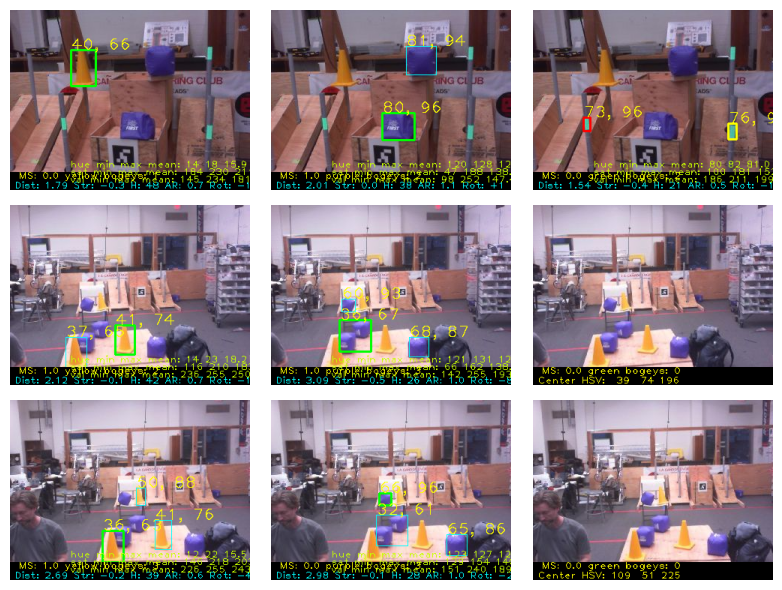

In [59]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,6))
for ix, ax in enumerate(axs.flatten()):
    ax.imshow(cv2.cvtColor(pimages[ix], cv2.COLOR_BGR2RGB))
    ax.axis('off')
fig.tight_layout()

In [60]:
# check we're getting the right data 
pd.DataFrame(stats['yellow'])

,HUE,SAT,VAL
0,16.0,195.0,178.0
1,16.0,188.0,179.0
2,16.0,205.0,180.0
3,16.0,213.0,175.0
4,15.0,193.0,182.0
...,...,...,...
808,17.0,187.0,226.0
809,20.0,166.0,232.0
810,19.0,167.0,228.0
811,22.0,146.0,251.0


#### get a histogram plot

In [40]:
def pipeline_plot(pipeline, save=False, title=''):
    # make a dataframe from the sub-image and add a cumulative density function (CDF)
    title = pipeline.color
    fs = 12
    data = {'HUE': pipeline.hue_stats, 'SAT': pipeline.sat_stats, 'VAL': pipeline.val_stats}
    df = pd.DataFrame(data, columns=['HUE', 'SAT', 'VAL'])
    df['hue_cdf'] = df.rank(method='average', pct=True)['HUE']
    df['sat_cdf'] = df.rank(method='average', pct=True)['SAT'] 
    df['val_cdf'] = df.rank(method='average', pct=True)['VAL'] 
    
    # set up a plot
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(14,4))

    axs.flat[0].imshow(cv2.cvtColor(pipeline.image, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f'{pipeline.color} H:{pipeline._hsv_threshold_hue}, S:{pipeline._hsv_threshold_saturation}, V:{pipeline._hsv_threshold_value}')
    
    axs.flat[1].imshow(pipeline.hsv_threshold_output)
    msg = f"  H: {pipeline.hue_stats.min()} {pipeline.hue_stats.max()} {pipeline.hue_stats.mean():.1f}"
    msg += f"  S: {pipeline.sat_stats.min()} {pipeline.sat_stats.max()} {pipeline.sat_stats.mean():.1f}"
    msg += f"  V: {pipeline.val_stats.min()} {pipeline.val_stats.max()} {pipeline.val_stats.mean():.1f}"
    axs[1].set_title(msg)
    
    axs.flat[0].axis('off')
    axs.flat[1].axis('off')
    
    # three histograms - could do all this with a for loop but I'll be explicit for the students 
    ax1 = df.hist(column='HUE', bins=20, weights=np.ones(len(df)) / len(df), ax=axs[2], color='purple', alpha=0.6)
    ax2 = df.hist(column='SAT', bins=20, weights=np.ones(len(df)) / len(df), ax=axs[2], color='orange', alpha=0.6)
    ax3 = df.hist(column='VAL', bins=20, weights=np.ones(len(df)) / len(df), ax=axs[2], color='cyan', alpha=0.6)
    # three cdfs
    ax4 = df.sort_values('HUE').plot(x ='HUE', y = 'hue_cdf', lw=3, style='--', ax=axs[2], fontsize=fs, color='purple', alpha=0.6)
    ax4 = df.sort_values('SAT').plot(x ='SAT', y = 'sat_cdf', lw=3, style='--', ax=axs[2], fontsize=fs, color='orange', alpha=0.6)
    ax4 = df.sort_values('VAL').plot(x ='VAL', y = 'val_cdf', lw=3, style='--', grid = True, ax=axs[2], fontsize=fs, color='cyan', alpha=0.6)
    # annotate the plot
    axs[2].legend(prop={'size': fs})
    axs[2].set_title(f'{title} HSV Histogram, n={len(df)}', fontsize=fs)
    axs[2].set_xlabel(f'Value of H, S, or V', fontsize=fs)
    fig.tight_layout()
    if save:
        plt.savefig('training_histogram.png', facecolor='w')


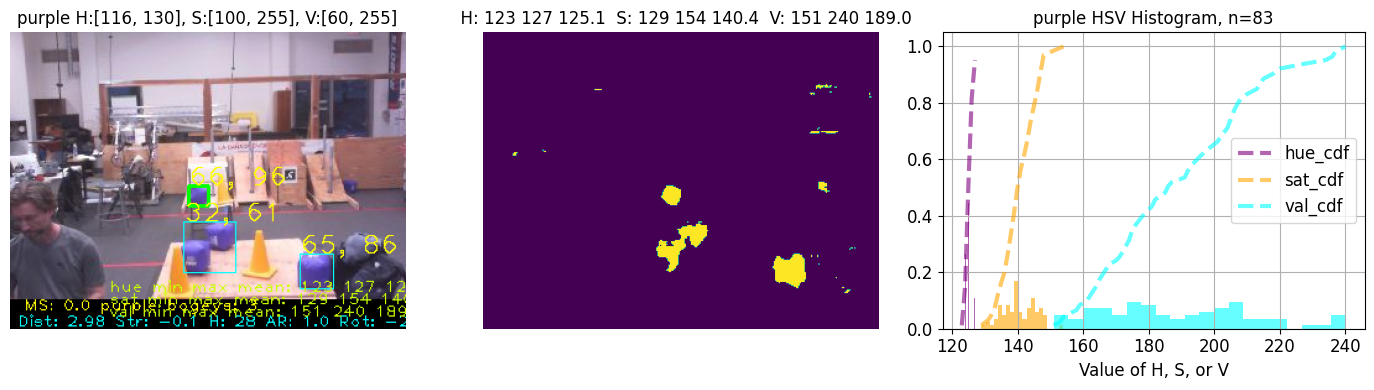

In [41]:
pipeline_plot(pipelines[1])

In [42]:
pipeline_all.process(img_rgb.copy())

{'yellow': {'targets': 3,
  'previous_targets': 0,
  'distances': [2.6931548853048417, 7.408509583877249, 2.9626570751875017],
  'strafes': [-0.20178284880583455, -0.5550776813457828, -0.2219751221617647],
  'heights': [42, 20, 37],
  'rotations': [-4.296875, -4.296875, -4.296875],
  'contours': []},
 'purple': {'targets': 4,
  'previous_targets': 0,
  'distances': [5.026479049138492,
   1.9126827058971483,
   2.977597366436126,
   8.937135715220153],
  'strafes': [-0.1356887071277407,
   -0.051632453049467016,
   -0.08037959236454616,
   -0.24125603205910565],
  'heights': [16, 41, 28, 9],
  'rotations': [-1.5468750000000007,
   -1.5468750000000007,
   -1.5468750000000007,
   -1.5468750000000007],
  'contours': []},
 'green': {'targets': 0,
  'previous_targets': 0,
  'distances': [],
  'strafes': [],
  'heights': [],
  'rotations': [],
  'contours': []}}

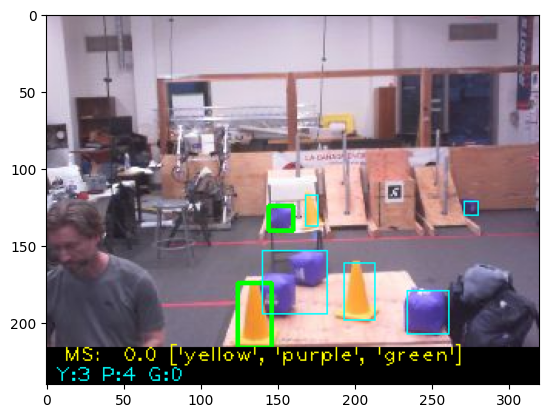

In [43]:
plt.imshow(cv2.cvtColor(pipeline_all.image, cv2.COLOR_BGR2RGB))

In [44]:
def histogram_plot(stats, color='yellow', save=False, title=''):
    # make a dataframe from the sub-image and add a cumulative density function (CDF)
    title = color
    fs = 12
    df = pd.DataFrame(stats[color], columns=['HUE', 'SAT', 'VAL'])
    df['hue_cdf'] = df.rank(method='average', pct=True)['HUE']
    df['sat_cdf'] = df.rank(method='average', pct=True)['SAT'] 
    df['val_cdf'] = df.rank(method='average', pct=True)['VAL'] 
    
    # find 99% confidence intervals
    hue_interval = [df['HUE'].mean() - 3 * np.std(df['HUE']), df['HUE'].mean() + 3 * np.std(df['HUE'])]
    sat_interval = [df['SAT'].mean() - 3 * np.std(df['SAT']), min(255, df['SAT'].mean() + 3 * np.std(df['SAT']))]
    val_interval = [df['VAL'].mean() - 3 * np.std(df['VAL']), min(255, df['VAL'].mean() + 3 * np.std(df['VAL']))]
    # print(hue_interval, sat_interval, val_interval)
    # set up a plot
    fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10,3))
    
    # three histograms - could do all this with a for loop but I'll be explicit for the students 
    ax1 = df.hist(column='HUE', bins=20, weights=np.ones(len(df)) / len(df), ax=axs, color='purple', alpha=0.6)
    ax2 = df.hist(column='SAT', bins=20, weights=np.ones(len(df)) / len(df), ax=axs, color='orange', alpha=0.6)
    ax3 = df.hist(column='VAL', bins=20, weights=np.ones(len(df)) / len(df), ax=axs, color='cyan', alpha=0.6)
    axs.axvspan(hue_interval[0], hue_interval[1], alpha=0.2, color='purple')
    axs.axvspan(sat_interval[0], sat_interval[1], alpha=0.2, color='orange')
    axs.axvspan(val_interval[0], val_interval[1], alpha=0.2, color='cyan')
    
    axs.annotate(f"{df['HUE'].mean():.1f}±{3*np.std(df['HUE']):.1f}", xy=(1+ hue_interval[1], 0.85), xytext=(hue_interval[1], 0.85))
    axs.annotate(f"{hue_interval[0]:.0f}-{hue_interval[1]:.0f}", xy=(1+ hue_interval[1], 0.75), xytext=(hue_interval[1], 0.75))
    axs.annotate(f"{df['SAT'].mean():.1f}±{3*np.std(df['SAT']):.1f}", xy=(1+ df['SAT'].mean(), 0.85), xytext=(df['SAT'].mean(), 0.65))
    axs.annotate(f"{sat_interval[0]:.0f}-{sat_interval[1]:.0f}", xy=(1+ df['SAT'].mean(), 0.65), xytext=(df['SAT'].mean(), 0.55))
    axs.annotate(f"{df['VAL'].mean():.1f}±{3*np.std(df['VAL']):.1f}", xy=(1+ df['VAL'].mean(), 0.85), xytext=(df['VAL'].mean(), 0.45))
    axs.annotate(f"{val_interval[0]:.0f}-{val_interval[1]:.0f}", xy=(1+ df['VAL'].mean(), 0.55), xytext=(df['VAL'].mean(), 0.35))
    # three cdfs
    ax4 = df.sort_values('HUE').plot(x ='HUE', y = 'hue_cdf', lw=3, style='--', ax=axs, fontsize=fs, color='purple', alpha=0.6)
    ax4 = df.sort_values('SAT').plot(x ='SAT', y = 'sat_cdf', lw=3, style='--', ax=axs, fontsize=fs, color='orange', alpha=0.6)
    ax4 = df.sort_values('VAL').plot(x ='VAL', y = 'val_cdf', lw=3, style='--', grid = True, ax=axs, fontsize=fs, color='cyan', alpha=0.6)
    # annotate the plot
    axs.legend(loc='upper right', prop={'size': fs-2})
    axs.set_title(f'{title} HSV Histogram, n={len(df)}', fontsize=fs)
    axs.set_xlabel(f'Value of H, S, or V', fontsize=fs)
    fig.tight_layout()
    if save:
        plt.savefig('training_histogram.png', facecolor='w')

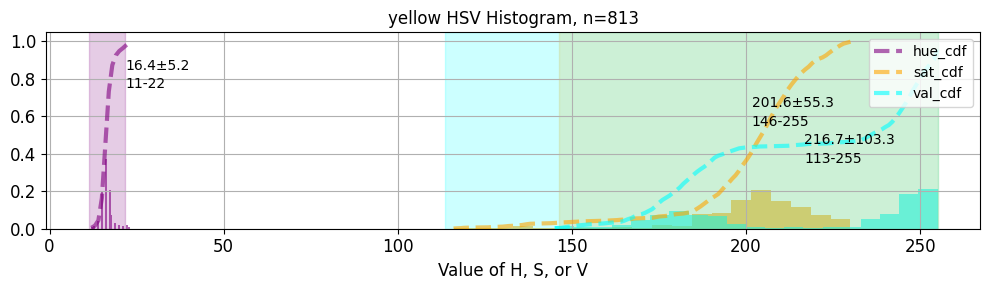

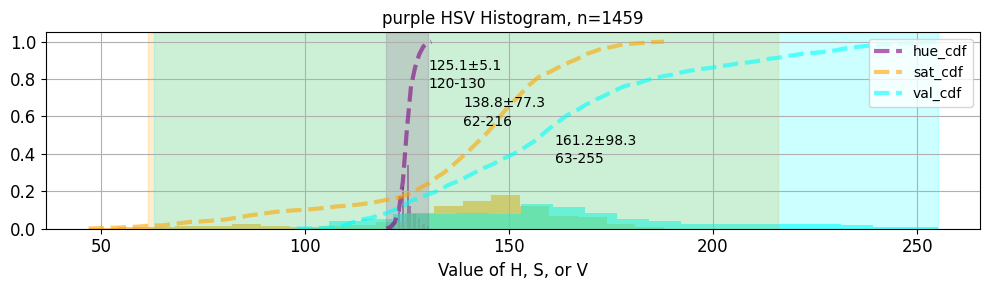

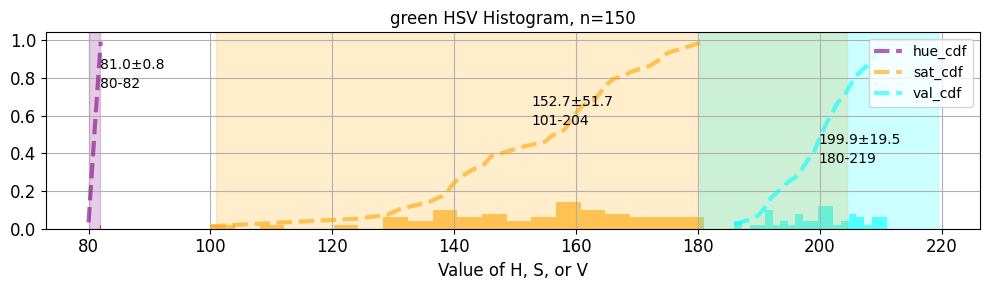

In [61]:
for color in colors:
    histogram_plot(stats, color)

In [46]:
from datetime import datetime

In [47]:
def generate_hsv_code(stats):
    ts = datetime.now().strftime("%Y%m%d %H:%M:%S")
    print(f'# Auto-generated HSV ranges {ts}')
    for idx, color in enumerate(stats.keys()):
        df = pd.DataFrame(stats[color], columns=['HUE', 'SAT', 'VAL'])
        start = 'if' if idx==0 else 'elif'
        print(f'{start} self.color == {color}:')
        hue_interval = [df['HUE'].mean() - 3 * np.std(df['HUE']), df['HUE'].mean() + 3 * np.std(df['HUE'])]
        sat_interval = [df['SAT'].mean() - 3 * np.std(df['SAT']), min(255, df['SAT'].mean() + 3 * np.std(df['SAT']))]
        val_interval = [df['VAL'].mean() - 3 * np.std(df['VAL']), min(255, df['VAL'].mean() + 3 * np.std(df['VAL']))]
        if hue_interval[1] - hue_interval[0] < 3:  # green is just too tight - pure tone from LEDs 
            hue_interval[0] = hue_interval[0] -1
            hue_interval[1] = hue_interval[1] + 1
        print(f'    self._hsv_threshold_hue = [{np.floor(hue_interval[0]):.0f}, {np.ceil(hue_interval[1]):.0f}]')
        print(f'    self._hsv_threshold_sat = [{np.floor(sat_interval[0]):.0f}, {np.ceil(sat_interval[1]):.0f}]')
        print(f'    self._hsv_threshold_val = [{np.floor(val_interval[0]):.0f}, {np.ceil(val_interval[1]):.0f}]')
    print('else:\n    pass\n')
        

In [48]:
generate_hsv_code(stats)

# Auto-generated HSV ranges 20230315 14:43:14
if self.color == yellow:
    self._hsv_threshold_hue = [11, 22]
    self._hsv_threshold_sat = [146, 255]
    self._hsv_threshold_val = [113, 255]
elif self.color == purple:
    self._hsv_threshold_hue = [119, 131]
    self._hsv_threshold_sat = [61, 217]
    self._hsv_threshold_val = [62, 255]
elif self.color == green:
    self._hsv_threshold_hue = [79, 83]
    self._hsv_threshold_sat = [100, 205]
    self._hsv_threshold_val = [180, 220]
else:
    pass

